PolygonPolygon True


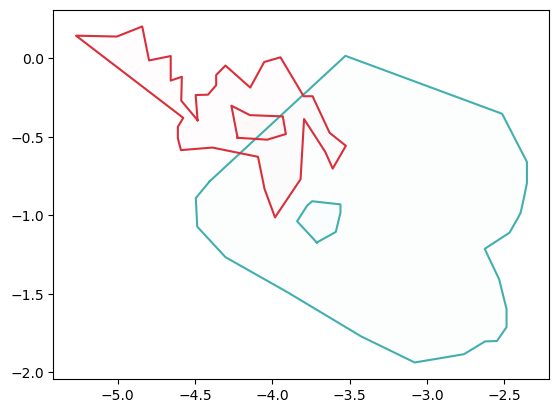

PolygonPolygon True


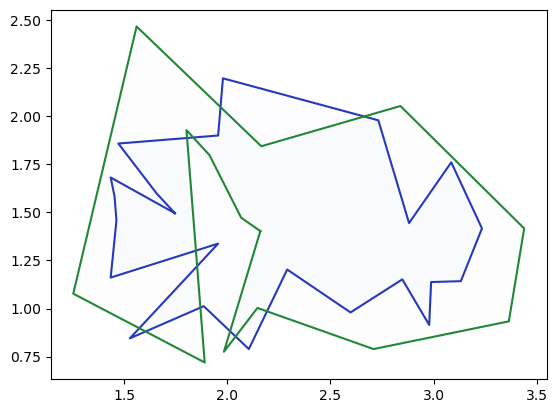

PolygonPolygon False


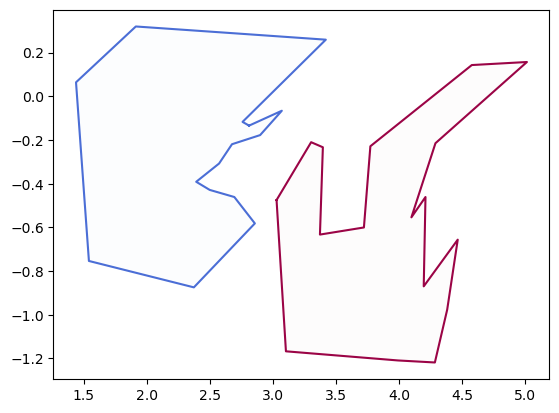

PolygonPolygon True


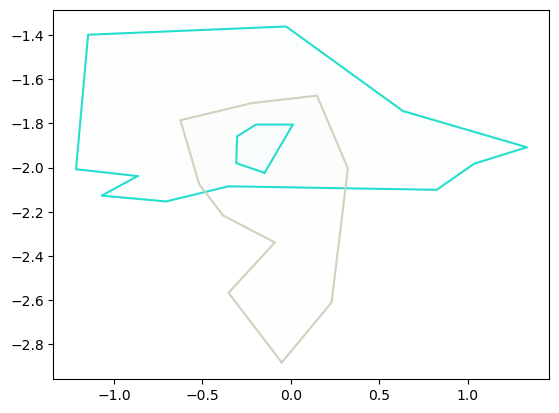

MultiPolygonPolygon True


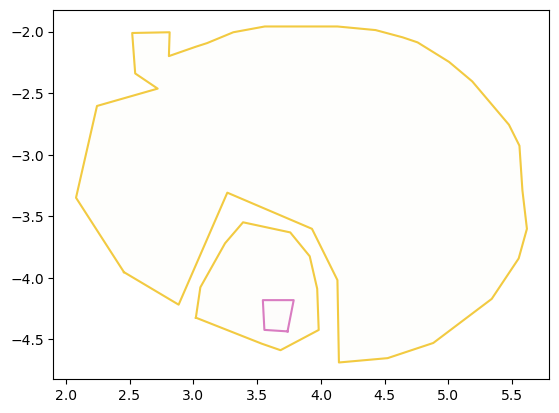

MultiPolygonPolygon True


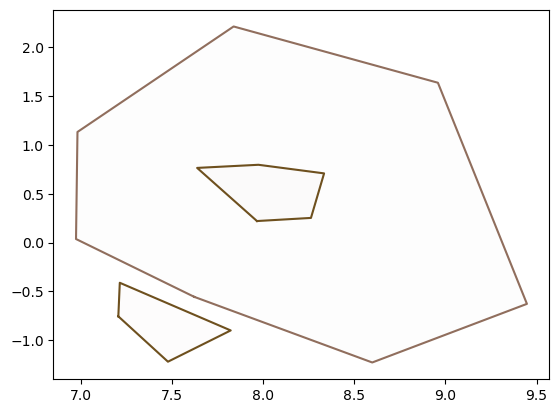

PolygonPolygon True


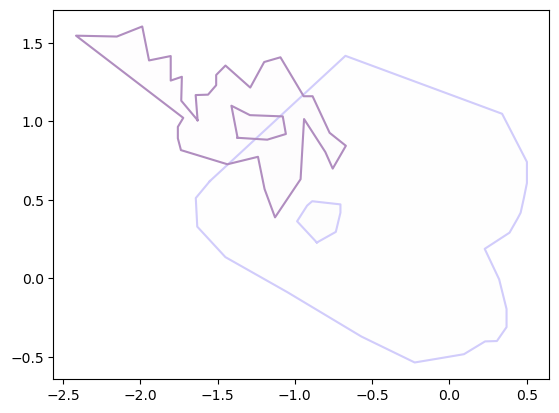

PolygonPolygon True


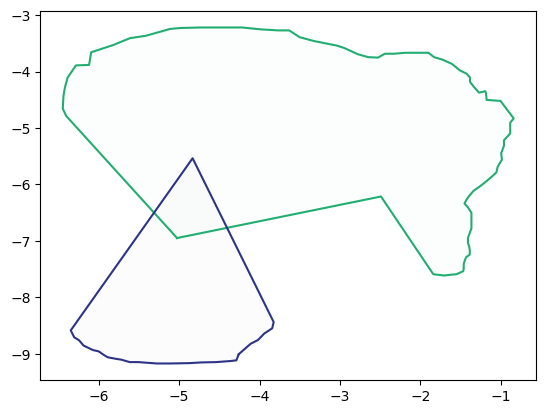

PolygonPolygon True


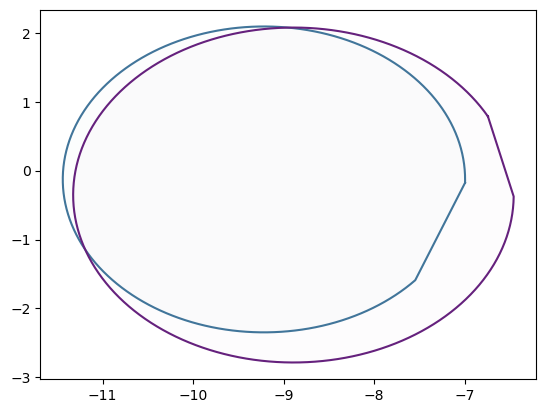

In [1]:
import bench_utils
import shapely
from shapely.geometry import shape
from tqdm import tqdm
from intersection.plotting import *
import matplotlib.pyplot as plt
import json

intersections = []

def append_data_set(file_name, intersections, PRINT_AND_DRAW=True):
    df, _ = bench_utils.read_dataset(file_name)
    shp_cnt = len(df)

    for i in tqdm(range(shp_cnt), disable=True):
        shp_1 = shape(df.iloc[i])
        x_l_1, y_b_1, x_r_1, y_t_1 = shapely.bounds(shp_1)
        for j in range(i + 1, shp_cnt):
            
            shp_2 = shape(df.iloc[j])
            x_l_2, y_b_2, x_r_2, y_t_2 = shapely.bounds(shp_2)

            bbox = [max(x_l_1, x_l_2), max(y_b_1, y_b_2), min(x_r_1, x_r_2), min(y_t_1, y_t_2)]
            x_l, y_b, x_r, y_t = bbox
            if x_r < x_l or y_t < y_b:
                continue

            types = [shp_1.geom_type, shp_2.geom_type]
            types.sort()
            t_1, t_2 = types
            type = t_1 + t_2
            if type == "LineStringLineString" and random.randint(0, 100) != 0:
                continue
            
            intersects = shapely.intersects(shp_1, shp_2)
            intersections += [type, shapely.to_wkt(shp_1, rounding_precision=-1), shapely.to_wkt(shp_2, rounding_precision=-1), str(intersects)]

            if PRINT_AND_DRAW:
                print(type, intersects)
                plot_geometry(shp_1)
                plot_geometry(shp_2)
                plt.show()


append_data_set("QGIS/Intersection_Tricky_Cases.shp", intersections, PRINT_AND_DRAW=True)
#append_data_set("data/lund_building_highway.json", intersections, False)
#append_data_set("data/world.json", intersections, False)

f = open("data/intersection/latest_export.json", "w")
f.write(json.dumps(intersections))
f.close()

#print(intersections)